In [17]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import time
import librosa #for audio processing
import librosa.display
import warnings
import pydot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import time

from scipy.io import wavfile #for audio processing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

warnings.filterwarnings("ignore")

In [2]:
# basic setup

audioPth        = 'speechsub'
resmpRate       = 16000
inputLength     = 16000
modelname       = 'speechRV1'

# Set up 'ggplot' style
plt.style.use('ggplot')     # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['font.family']     = 'Arial'

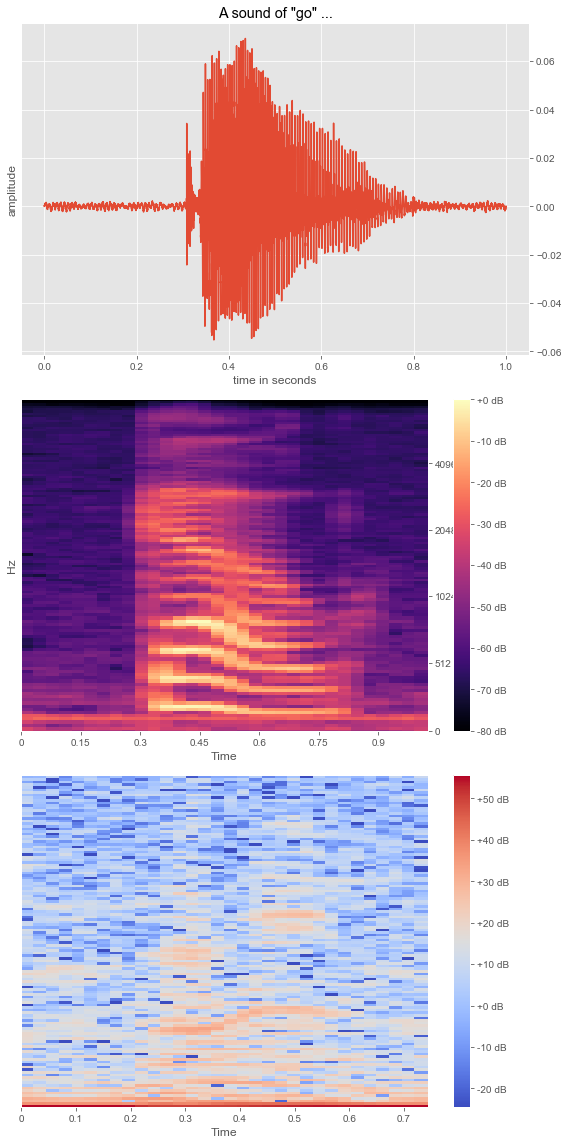

In [3]:
# Plot a 'go' soundwave

goSample    = os.path.join(audioPth,
                           'go',
                           '00f0204f_nohash_1.wav')

(smp,smpR)  = librosa.load(goSample,sr=16000)

melSpc = librosa.feature.melspectrogram(y=smp, sr=smpR, n_fft=2048, power=2)
melSpc_db = librosa.power_to_db(melSpc, ref=np.max)

mfcc = librosa.feature.mfcc(y=smp, sr=smpR, n_mfcc=256)
mfcc_db = librosa.amplitude_to_db(mfcc)

plt.figure(figsize=(8,16))
plt.subplot(311)
plt.plot(np.linspace(0,                 # Start
                     len(smp)/smpR,     # Stop (convert sample number into second)
                     len(smp)),         # Number of points
                     smp)
plt.title('A sound of "go" ...')
plt.xlabel('time in seconds')
plt.ylabel('amplitude')

plt.subplot(312)
librosa.display.specshow(melSpc_db, x_axis='time', y_axis='mel', sr=16000, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

plt.subplot(313)
librosa.display.specshow(mfcc_db, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

plt.show()

Inspecting data  ... 


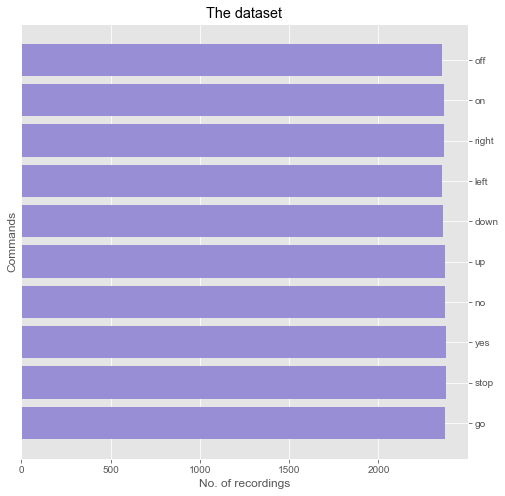

In [4]:
print("Inspecting data  ... ")
# Inspect the data set

labels      = ["go",
               "stop",
               "yes", 
               "no", 
               "up", 
               "down", 
               "left", 
               "right", 
               "on", 
               "off"]

# labels      = ["up", 
#                "down"]
#                "left", 
#                "right"]

# Check the number of records available in
# each category
numOfRecords= []

for lbl in labels:
    pth     = os.path.join(audioPth,lbl)    # Get the path (the directory) for each label
    records = [f for f in os.listdir(pth) if f.endswith('.wav')]
# Get all the wave files in each directory
   
    numOfRecords.append(len(records))       # Get the number of wave files in each directory
    

plt.figure(figsize=(8,8))
plt.barh(np.arange(len(labels)), 
         numOfRecords,
         color="C2")
plt.xlabel('No. of recordings')
plt.ylabel('Commands')
plt.yticks(np.arange(len(labels)), labels)
plt.title('The dataset')
plt.show()

Wall time: 1min 3s


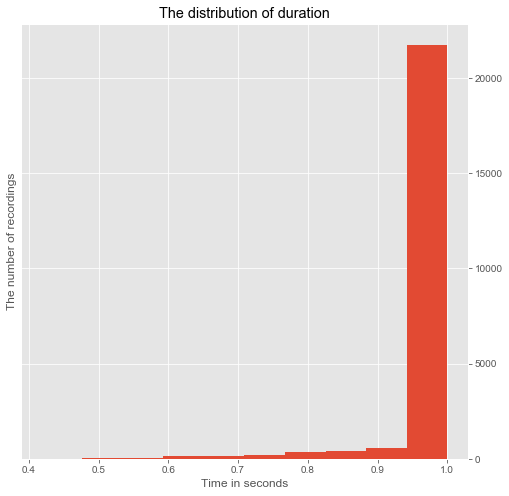

In [5]:
%%time
# Check distribution of durations in 
# the dataset
durations   = []

for lbl in labels:
    pth     = os.path.join(audioPth,lbl)    # Get the path (the directory) for each label
    records = [f for f in os.listdir(pth) if f.endswith('.wav')]
# Get all the wave files in each directory
    
    for rcd in records:
        (smpR,smp)  = wavfile.read(os.path.join(pth,rcd))
        
        durations.append(float(len(smp)/smpR))      
# Get the duration for each wave file

plt.figure(figsize=(8,8))
plt.title('The distribution of duration')
plt.ylabel('The number of recordings')
plt.xlabel('Time in seconds')
durationHist    = plt.hist(durations)

In [6]:
%%time
# Prepare dataset for training 
# (Get only sample with a duration 
# of 1 second)

print("Preparing dataset ... ")
allRecords  = []
allLabels   = []
allMelSpec = []
allMfcc = []

for lbl in labels:
    pth     = os.path.join(audioPth,lbl)    # Get the path (the directory) for each label
    records = [f for f in os.listdir(pth) if f.endswith('.wav')]

    for rcd in records:
        (smp,smpR)  = librosa.load(os.path.join(pth,rcd),sr=16000)
        smp         = librosa.resample(smp,
                                       smpR, 
                                       resmpRate)

        melSpec = librosa.feature.melspectrogram(y=smp, sr=smpR)
        melSpec_db = librosa.power_to_db(melSpec, ref=np.max)
        mfcc = librosa.feature.mfcc(y=smp, sr=smpR, n_mfcc=1024)
        mfcc_db = librosa.power_to_db(mfcc)
        
        if (len(smp)==inputLength):
            allRecords.append(smp)
            allLabels.append(lbl)
            allMelSpec.append(melSpec_db)
            allMfcc.append(mfcc_db)
            
allRecords  = np.array(allRecords).reshape(-1,inputLength,1)

Preparing dataset ... 
Wall time: 3min 56s


In [10]:
len(allMelSpec)

21312

In [11]:
# Pralllibrosa.power_to_db label for training                                            
le      = LabelEncoder()
lbls    = le.fit_transform(allLabels)
classes = list(le.classes_)                 # the output is a funny numpy str_ object
classes = [str(c) for c in classes]    # convert each output in the list to string
lbls    = to_categorical(lbls,num_classes=len(classes)) 

In [14]:
len(allMfcc)

21312

In [18]:
# Split the data into training and 
# validation set

# mfccList = []
# for m in allMfcc:
# #     if len(m) > 100:
# #         m = m[:100]
#     mfccList.append(m[...,np.newaxis])

# mfccStack = np.stack(mfccList)
    
melSpecList = []

for mel in allMelSpec:
    melSpecList.append(mel[...,np.newaxis])
melSpecStack = np.stack(melSpecList)
    
(trDat,
 vlDat,
 trLbl, 
 vlLbl) = train_test_split(melSpecStack,
                           lbls,
                           stratify=lbls,
                           test_size=0.2,
                           random_state=229,
                           shuffle=True)

In [19]:
melSpecList[0].shape

(128, 32, 1)

In [20]:
# Create the deep learning model
def createModel(inputRow, inputCol):
    ipt = Input(shape=(inputRow, inputCol, 1))

    x   = Conv2D(32, (3,3), padding='same', strides=(2,2))(ipt)
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    
    x   = Conv2D(32, (3,3), padding='same', strides=(2,2))(x)
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    
    x   = Conv2D(64, (3,3), padding='same', strides=(2,2))(x)
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    
    x   = Conv2D(64, (3,3), padding='same', strides=(2,2))(x)
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    
    x   = Conv2D(128, (3,3), padding='same', strides=(2,2))(x)
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    
    x   = Conv2D(128, (3,3), padding='same', strides=(2,2))(x)
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    x   = Dropout(0.5)(x)
    
    x   = Conv2D(256, (3,3), padding='same', strides=(2,2))(x)
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    
    x   = Conv2D(256, (3,3), padding='same', strides=(2,2))(x)
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    x   = Dropout(0.5)(x)
       
    x   = Flatten()(x)
    x   = Dense(1024, activation='relu')(x)   
    x   = Dense(len(classes), activation='softmax')(x)
    
    model = Model(ipt, x)
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    
    return model

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 32, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 16, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 16, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 64, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 8, 32)         9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 8, 32)         128       
_________

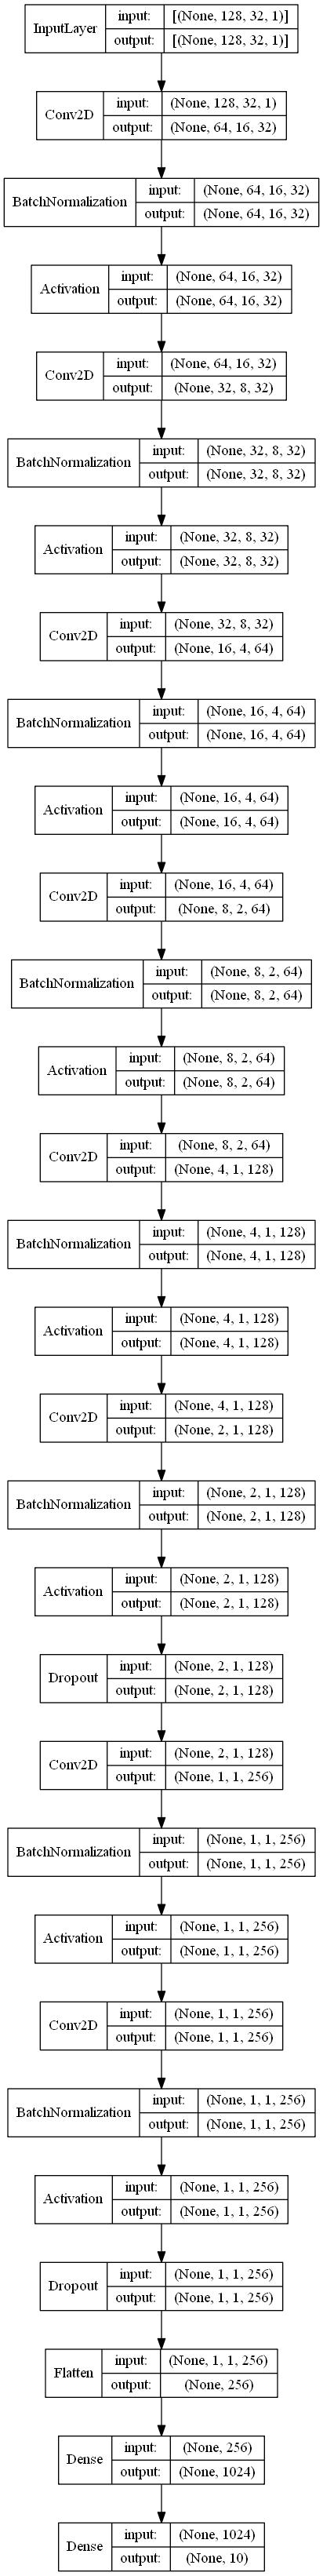

In [21]:
# Setup the models
D2InputRow = 128
D2InputCol = 32

model       = createModel(D2InputRow, D2InputCol) # This is meant for training
modelGo     = createModel(D2InputRow, D2InputCol) # This is used for final testing

model.summary()

plot_model(model, 
           to_file=modelname+'_plot.png', 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

In [22]:
# Create checkpoint for the training
# This checkpoint performs model saving when
# an epoch gives highest testing accuracy
filepath        = modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_loss', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='min')
reduceLR        = ReduceLROnPlateau(monitor='loss',
                                    mode='min',
                                    patience=5,
                                    min_delta=0.01)
                            # Log the epoch detail into csv
csv_logger      = CSVLogger(modelname +'.csv')
callbacks_list  = [checkpoint,csv_logger, reduceLR]

In [23]:
# Fit the model
# This is where the training starts
model.fit(trDat, 
          trLbl, 
          validation_data=(vlDat, vlLbl), 
          epochs=100, 
          batch_size=32,
          shuffle=True,
          callbacks=callbacks_list)

Train on 17049 samples, validate on 4263 samples
Epoch 1/100
17049/17049 [==============================] - 27s 2ms/sample - loss: 1.5174 - acc: 0.4527 - val_loss: 1.0297 - val_acc: 0.6280
Epoch 2/100
17049/17049 [==============================] - 11s 622us/sample - loss: 0.7973 - acc: 0.7228 - val_loss: 0.6534 - val_acc: 0.7825
Epoch 3/100
17049/17049 [==============================] - 10s 579us/sample - loss: 0.6120 - acc: 0.7914 - val_loss: 0.4627 - val_acc: 0.8412
Epoch 4/100
17049/17049 [==============================] - 10s 589us/sample - loss: 0.5124 - acc: 0.8269 - val_loss: 0.4711 - val_acc: 0.8346
Epoch 5/100
17049/17049 [==============================] - 11s 647us/sample - loss: 0.4485 - acc: 0.8539 - val_loss: 0.4068 - val_acc: 0.8668
Epoch 6/100
17049/17049 [==============================] - 10s 567us/sample - loss: 0.4036 - acc: 0.8687 - val_loss: 0.3990 - val_acc: 0.8639
Epoch 7/100
17049/17049 [==============================] - 10s 588us/sample - loss: 0.3646 - acc: 0.8

In [24]:
# Now the training is complete, we get
# another object to load the weights
# compile it, so that we can do 
# final evaluation on it
modelGo.load_weights(filepath)
modelGo.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

In [25]:
# Make classification on the test dataset
predicts    = modelGo.predict(vlDat)

# Prepare the classification output
# for the classification report
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(vlLbl,axis=1)

testScores  = metrics.accuracy_score(testout,predout)
confusion   = metrics.confusion_matrix(testout,predout)

print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,predout,target_names=classes,digits=4))
print(confusion)

Best accuracy (on testing dataset): 91.70%
              precision    recall  f1-score   support

        down     0.8874    0.9163    0.9016       430
          go     0.8750    0.8333    0.8537       420
        left     0.9423    0.9423    0.9423       433
          no     0.8838    0.8690    0.8764       420
         off     0.9494    0.8741    0.9102       429
          on     0.9287    0.9596    0.9439       421
       right     0.9801    0.9165    0.9472       431
        stop     0.9384    0.9448    0.9416       435
          up     0.8235    0.9515    0.8829       412
         yes     0.9742    0.9606    0.9674       432

    accuracy                         0.9170      4263
   macro avg     0.9183    0.9168    0.9167      4263
weighted avg     0.9189    0.9170    0.9171      4263

[[394  10   1   8   2   3   1   9   2   0]
 [ 20 350   0  33   1   4   2   3   4   3]
 [  1   2 408   0   1   3   0   1  12   5]
 [ 20  27   1 365   2   1   0   0   3   1]
 [  2   0   0   1 375  10 

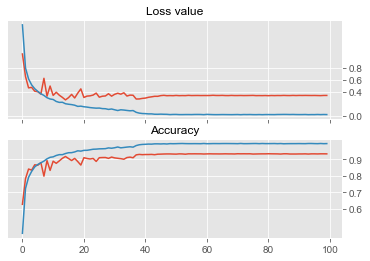

In [27]:
records = pd.read_csv(modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'])
plt.plot(records['loss'])
plt.yticks([0.00,0.40,0.60,0.80])
plt.title('Loss value',fontsize=12)

ax = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records['val_acc'])
plt.plot(records['acc'])
plt.yticks([0.6,0.7,0.8,0.9])
plt.title('Accuracy',fontsize=12)
plt.show()

In [30]:
# Create a function to make prediction 
# straightly from a wave file
                                            
def commandPred(file):
    (smp,smpR)  = librosa.load(file,sr=16000)
    smp         = librosa.resample(smp,
                                   smpR, 
                                   resmpRate)
    mel = librosa.feature.melspectrogram(y=smp, sr=smpR)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel         = mel_db.reshape(-1, D2InputRow, D2InputCol,1)
    pred        = modelGo.predict(mel)
    pred        = np.argmax(pred,axis=1)
    
    return classes[pred[0]]

In [31]:
wfile       = 'voice01.wav'
pred        = commandPred(wfile)
print("")
print("The command predicted from '%s' is '%s'." % (wfile,pred) )


The command predicted from 'voice01.wav' is 'right'.
